In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os, sys
cwd = os.getcwd()

api_path_mnist = os.path.join(cwd, '..', 'tools', 'mnist_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_mnist_scratch_path = os.path.join(cwd, '..', 'models', 'models_mnist')
sys.path.append(api_path_mnist)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [8]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from dcgan import Discriminator, Generator

from functools import partial

from general_utils import to_var, DotDict, to_np

from mh_sampling import mh_sampling, mh_sampling_from_scratch
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from sir_ais_sampling import (sir_independent_sampling,
                              sir_correlated_sampling)

from metrics import inception_score

# Test model from https://github.com/csinva/gan-vae-pretrained-pytorch

In [9]:
d_path = os.path.join(models_mnist_scratch_path, "netD_epoch_99.pth")
g_path = os.path.join(models_mnist_scratch_path, "netG_epoch_99.pth")
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
dckpt = torch.load(d_path, map_location=device)
gckpt = torch.load(g_path, map_location=device)

In [18]:
D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

D.load_state_dict(dckpt)
G.load_state_dict(gckpt)

G = G.to(device)
D = D.to(device)

In [19]:
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [20]:
D

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [21]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = G(fixed_noise)

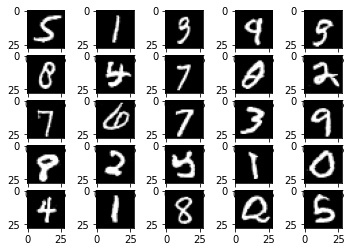

In [22]:
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 5, 5

for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [23]:
outputs = D(fake_images)
print(outputs)

tensor([0.0153, 0.4314, 0.2331, 0.0228, 0.2569, 0.1876, 0.7526, 0.4622, 0.3156,
        0.1061, 0.4277, 0.0287, 0.0654, 0.5251, 0.0572, 0.0081, 0.4361, 0.1287,
        0.4762, 0.6040, 0.0048, 0.3051, 0.1190, 0.1097, 0.0806],
       device='cuda:4', grad_fn=<SqueezeBackward1>)


# ULA

In [ ]:
z_dim = G.z_dim
device = args.device
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)